In [2]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.1 MB/s eta 0:00:00


In [6]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.6 MB/s eta 0:00:00



Métricas por hora:


,hora,total_enviado,total_engajado,custo,taxa_engajamento,label_hora
0,0,230,98,132,0.426087,00:00
1,1,191,75,116,0.392670,01:00
2,2,211,94,117,0.445498,02:00
3,3,235,109,126,0.463830,03:00
4,4,195,87,108,0.446154,04:00
5,5,212,86,126,0.405660,05:00
6,6,196,73,123,0.372449,06:00
7,7,216,89,127,0.412037,07:00
8,8,199,80,119,0.402010,08:00
9,9,205,75,130,0.365854,09:00



Comparação Greedy x A* (L = 1..5):


,L,horas_gulosa,engajado_gulosa,custo_gulosa,taxa_eng_gulosa,horas_astar,engajado_astar,custo_astar,taxa_eng_astar
0,1,[13:00],113,115,0.495614,[13:00],113,115,0.495614
1,2,"[13:00, 15:00]",210,223,0.484392,"[03:00, 13:00]",222,241,0.479722
2,3,"[13:00, 15:00, 17:00]",303,328,0.479494,"[03:00, 13:00, 15:00]",319,349,0.477538
3,4,"[03:00, 13:00, 15:00, 17:00]",412,454,0.475578,"[03:00, 13:00, 15:00, 17:00]",412,454,0.475578
4,5,"[03:00, 13:00, 15:00, 16:00, 17:00]",505,562,0.473000,"[03:00, 13:00, 15:00, 16:00, 17:00]",505,562,0.473000


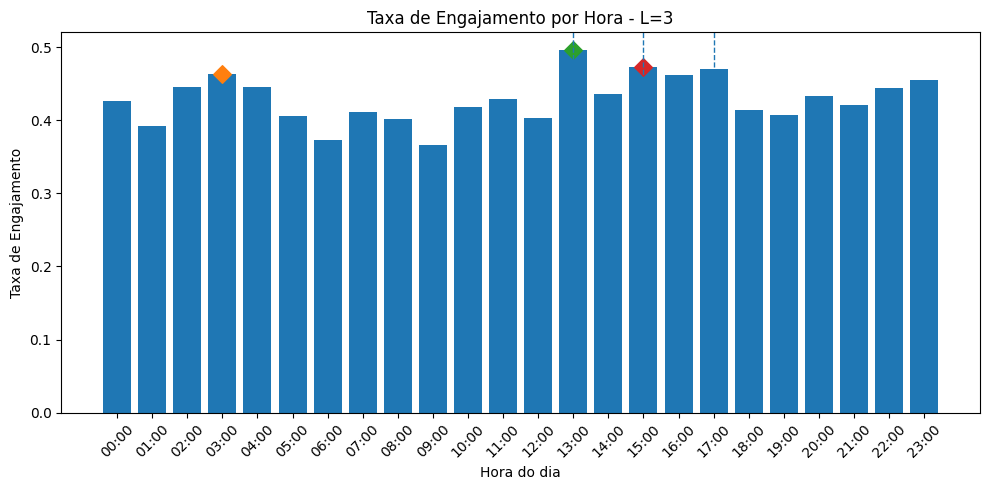

In [4]:
# === Importações ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader

# === Leitura do CSV ===
df_fila_campanha = pd.read_csv("CampaignQueue.csv", sep=";")

# === Pré-processamento de datas ===
colunas_tempo = ['scheduledAt', 'sendAt', 'createdAt']
coluna_data = next((c for c in colunas_tempo if c in df_fila_campanha.columns), None)
if coluna_data is None:
    raise ValueError("Nenhuma coluna de data encontrada no CSV.")
df_fila_campanha[coluna_data] = pd.to_datetime(df_fila_campanha[coluna_data], errors='coerce', dayfirst=True)
df_fila_campanha['hora'] = df_fila_campanha[coluna_data].dt.hour

coluna_status = 'status' if 'status' in df_fila_campanha.columns else None
coluna_resposta = 'response' if 'response' in df_fila_campanha.columns else None

# === Função de engajamento ===
def esta_engajado(linha):
    engajado = False
    if coluna_status and pd.notna(linha.get(coluna_status)):
        try:
            if str(int(float(linha[coluna_status]))) == '4':
                engajado = True
        except Exception:
            if str(linha[coluna_status]).strip().lower() in ['read','4']:
                engajado = True
    if coluna_resposta and pd.notna(linha.get(coluna_resposta)) and str(linha[coluna_resposta]).strip() != '':
        engajado = True
    return engajado

df_fila_campanha['engajado'] = df_fila_campanha.apply(esta_engajado, axis=1)
df_fila_campanha['enviado'] = 1

# === Métricas por hora ===
horas = list(range(24))
grupo_horas = df_fila_campanha.groupby('hora').agg(
    total_enviado=('enviado','sum'),
    total_engajado=('engajado','sum')
).reindex(horas, fill_value=0).reset_index()

grupo_horas['custo'] = grupo_horas['total_enviado'] - grupo_horas['total_engajado']
grupo_horas['taxa_engajamento'] = grupo_horas.apply(
    lambda r: (r['total_engajado']/r['total_enviado']) if r['total_enviado']>0 else 0.0, axis=1
)
grupo_horas = grupo_horas.fillna(0)
grupo_horas['label_hora'] = grupo_horas['hora'].apply(lambda h: f"{int(h):02d}:00")

print("\nMétricas por hora:")
display(grupo_horas)

# === Funções Greedy e A* ===
def selecao_gulosa(df_grupo, L=3):
    df_ordenado = df_grupo.sort_values('taxa_engajamento', ascending=False)
    selecionados = df_ordenado.head(L).copy()
    selecionados = selecionados.sort_values('hora')
    return selecionados

def a_star_melhor_conjunto(df_grupo, L=3, beta=0.5):
    horas = list(df_grupo['hora'].astype(int))
    engajados = dict(zip(horas, df_grupo['total_engajado']))
    custos = dict(zip(horas, df_grupo['custo']))

    def heuristica(vagas_restantes, conjunto_escolhido):
        if vagas_restantes <= 0: return 0.0
        disponiveis = [eng for h, eng in engajados.items() if h not in conjunto_escolhido]
        disponiveis.sort(reverse=True)
        return sum(disponiveis[:vagas_restantes])

    melhor_pontuacao = -1e18
    melhor_conjunto = None
    pq = []
    inicio_escolhido = tuple()
    g_inicio = 0.0
    f_inicio = -(g_inicio + heuristica(L, set(inicio_escolhido)))
    heappush(pq, (f_inicio, -g_inicio, inicio_escolhido))
    visitados = set()

    while pq:
        f, neg_g, escolhido = heappop(pq)
        g = -neg_g
        conjunto_escolhido = set(escolhido)
        if escolhido in visitados: continue
        visitados.add(escolhido)

        if len(escolhido) == L:
            if g > melhor_pontuacao:
                melhor_pontuacao = g
                melhor_conjunto = escolhido
            continue

        ultimo = escolhido[-1] if len(escolhido) > 0 else -1
        for h in horas:
            if h in conjunto_escolhido or h <= ultimo: continue
            novo_escolhido = tuple(list(escolhido) + [h])
            if novo_escolhido in visitados: continue
            novo_g = g + engajados[h] - beta * custos[h]
            vagas_restantes = L - len(novo_escolhido)
            h_est = heuristica(vagas_restantes, set(novo_escolhido))
            f_novo = -(novo_g + h_est)
            heappush(pq, (f_novo, -novo_g, novo_escolhido))

    if melhor_conjunto is None: return pd.DataFrame(columns=df_grupo.columns)
    linhas_selecionadas = df_grupo[df_grupo['hora'].isin(melhor_conjunto)].sort_values('hora')
    return linhas_selecionadas

# === Comparação Greedy x A* ===
resultados = []
for L in range(1,6):
    greedy_sel = selecao_gulosa(grupo_horas, L=L)
    a_star_sel = a_star_melhor_conjunto(grupo_horas, L=L, beta=0.5)

    def calcular_metricas(df_sel, beta=0.5):
        return int(df_sel['total_engajado'].sum()), int(df_sel['custo'].sum()), float(df_sel['taxa_engajamento'].mean())

    g_eng, g_custo, g_taxa = calcular_metricas(greedy_sel)
    a_eng, a_custo, a_taxa = calcular_metricas(a_star_sel)

    resultados.append({
        'L': L,
        'horas_gulosa': list(greedy_sel['label_hora']),
        'engajado_gulosa': g_eng,
        'custo_gulosa': g_custo,
        'taxa_eng_gulosa': g_taxa,
        'horas_astar': list(a_star_sel['label_hora']),
        'engajado_astar': a_eng,
        'custo_astar': a_custo,
        'taxa_eng_astar': a_taxa
    })

df_resultados = pd.DataFrame(resultados)
print("\nComparação Greedy x A* (L = 1..5):")
display(df_resultados)

# === Gráfico para L=3 ===
L_exemplo = 3
selecionados_gulosa_L3 = selecao_gulosa(grupo_horas, L=L_exemplo)
selecionados_astar_L3 = a_star_melhor_conjunto(grupo_horas, L=L_exemplo, beta=0.5)

plt.figure(figsize=(10,5))
plt.bar(grupo_horas['hora'], grupo_horas['taxa_engajamento'])
plt.xticks(grupo_horas['hora'], grupo_horas['label_hora'], rotation=45)
plt.xlabel("Hora do dia")
plt.ylabel("Taxa de Engajamento")
plt.title(f"Taxa de Engajamento por Hora - L={L_exemplo}")

for h in selecionados_gulosa_L3['hora']:
    plt.axvline(h, linestyle='--', linewidth=1.0)
for h in selecionados_astar_L3['hora']:
    plt.scatter([h], [grupo_horas.loc[grupo_horas['hora']==h,'taxa_engajamento'].values[0]], marker='D', s=80)

os.makedirs('/mnt/data/IA', exist_ok=True)
caminho_plot = '/mnt/data/IA/taxa_engajamento_por_hora_L3.png'
plt.tight_layout()
plt.savefig(caminho_plot)
plt.show()
